In [91]:
import yfinance as yf
import pandas as pd

# Fetch daily S&P 500 data
sp500_data = yf.download('^GSPC', start='2000-01-01', end='2024-01-01')

# Calculate additional features for S&P 500 data
sp500_data['daily_return'] = sp500_data['Close'].pct_change() #might need
sp500_data['volatility'] = sp500_data['daily_return'].rolling(window=20).std()

###sp500_data['ma_200'] = sp500_data['Close'].rolling(window=200).mean() # for long term


# Calculate the 200-day moving return
sp500_data['200_day_return'] = sp500_data['Close'].pct_change(periods=200)

[*********************100%%**********************]  1 of 1 completed


In [92]:
sp500 = sp500_data.dropna()
sp500.shape

(5837, 9)

In [93]:
import pandas_datareader.data as pdr
import yfinance as yf
import pandas as pd

# Fetch economic indicators from FRED
gdp = pdr.get_data_fred('GDP', start='2000-01-01', end='2024-01-01') #quaterly

inflation = pdr.get_data_fred('CPIAUCSL', start='2000-01-01', end='2024-01-01')  # CPI for inflation
unemployment = pdr.get_data_fred('UNRATE', start='2000-01-01', end='2024-01-01')
interest_rate = pdr.get_data_fred('FEDFUNDS', start='2000-01-01', end='2024-01-01')

# Rename columns for clarity
gdp.rename(columns={'GDP': 'GDP'}, inplace=True)
inflation.rename(columns={'CPIAUCSL': 'Inflation'}, inplace=True)
unemployment.rename(columns={'UNRATE': 'Unemployment'}, inplace=True)
interest_rate.rename(columns={'FEDFUNDS': 'Interest_Rate'}, inplace=True)

In [94]:
inflation.head()

,Inflation
DATE,
2000-01-01,169.3
2000-02-01,170.0
2000-03-01,171.0
2000-04-01,170.9
2000-05-01,171.2


In [95]:
GDP = gdp.resample('D').ffill()
GDP.loc['2020-03-28':'2020-04-01'] 

,GDP
DATE,
2020-03-28,21706.513
2020-03-29,21706.513
2020-03-30,21706.513
2020-03-31,21706.513
2020-04-01,19913.143


In [96]:
Inflation = inflation.resample('D').ffill()
Unemployment = unemployment.resample('D').ffill()
Interest_rate = interest_rate.resample('D').ffill()

In [97]:
merged_data = sp500.join([Inflation, Unemployment, Interest_rate], how='left')
merged_data.head()

,Open,High,Low,Close,Adj Close,Volume,daily_return,volatility,200_day_return,Inflation,Unemployment,Interest_Rate
Date,,,,,,,,,,,,
2000-10-17,1374.619995,1380.989990,1342.339966,1349.969971,1349.969971,1.161500e+09,-0.017932,0.013576,-0.072326,173.9,3.9,6.51
2000-10-18,1349.969971,1356.650024,1305.790039,1342.130005,1342.130005,1.441700e+09,-0.005808,0.013576,-0.040938,173.9,3.9,6.51
2000-10-19,1342.130005,1389.930054,1342.130005,1388.760010,1388.760010,1.297900e+09,0.034743,0.016088,-0.009521,173.9,3.9,6.51
2000-10-20,1388.760010,1408.469971,1382.189941,1396.930054,1396.930054,1.177400e+09,0.005883,0.016181,-0.004646,173.9,3.9,6.51
2000-10-23,1396.930054,1406.959961,1387.750000,1395.780029,1395.780029,1.046800e+09,-0.000823,0.016139,-0.031697,173.9,3.9,6.51


In [98]:
# convert index date into date
merged_data.index = pd.to_datetime(merged_data.index)

#shape of merged_data
merged_data.shape


(5837, 12)

In [99]:
# Finding rows with any NaNs
rows_with_any_nans = merged_data[merged_data.isna().any(axis=1)]
print("Rows with any NaNs:")
print(rows_with_any_nans)

Rows with any NaNs:
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, daily_return, volatility, 200_day_return, Inflation, Unemployment, Interest_Rate]
Index: []


In [100]:
from sklearn.preprocessing import StandardScaler
# Separating the features and target
features = merged_data.drop(columns=['200_day_return'])
target = merged_data['200_day_return']
# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Converting the scaled features back to a DataFrame
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Adding the target column back to the scaled DataFrame
merged_data_scaled = pd.concat([features_scaled_df, target.reset_index(drop=True)], axis=1)

merged_data_scaled.head()

,Open,High,Low,Close,Adj Close,Volume,daily_return,volatility,Inflation,Unemployment,Interest_Rate,200_day_return
0,-0.574076,-0.576042,-0.595653,-0.597161,-0.597161,-1.525636,-1.480341,0.470948,-1.611404,-0.976013,2.713256,-0.072326
1,-0.597020,-0.598583,-0.629853,-0.604457,-0.604457,-1.335224,-0.495300,0.470884,-1.611404,-0.976013,2.713256,-0.040938
2,-0.604317,-0.567763,-0.595850,-0.561066,-0.561066,-1.432944,2.799138,0.837456,-1.611404,-0.976013,2.713256,-0.009521
3,-0.560915,-0.550594,-0.558365,-0.553463,-0.553463,-1.514831,0.454461,0.851056,-1.611404,-0.976013,2.713256,-0.004646
4,-0.553310,-0.551993,-0.553163,-0.554533,-0.554533,-1.603582,-0.090368,0.844903,-1.611404,-0.976013,2.713256,-0.031697


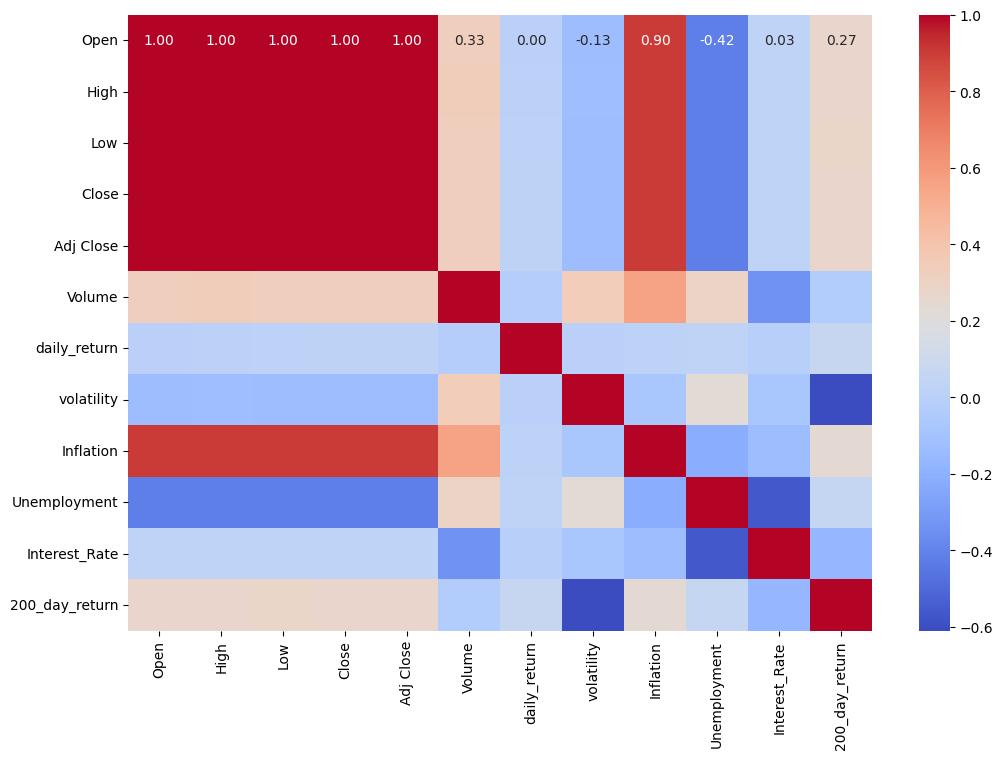

In [101]:
# correaltion matrix merged_data_scaled
correlation_matrix = merged_data_scaled.corr()
# heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [102]:
# Selecting the relevant columns
data = merged_data_scaled[[ '200_day_return', 'Inflation', 'Unemployment', 'Interest_Rate']]
# add Date column from merged_data

data.shape


(5837, 4)

In [103]:
# head of data
data.head()

,200_day_return,Inflation,Unemployment,Interest_Rate
0,-0.072326,-1.611404,-0.976013,2.713256
1,-0.040938,-1.611404,-0.976013,2.713256
2,-0.009521,-1.611404,-0.976013,2.713256
3,-0.004646,-1.611404,-0.976013,2.713256
4,-0.031697,-1.611404,-0.976013,2.713256


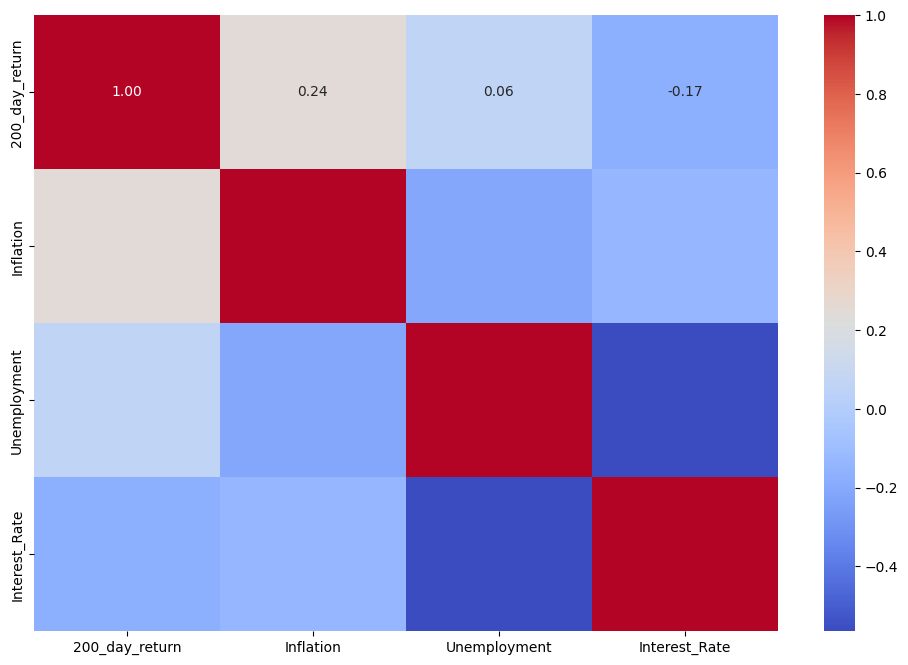

In [104]:
# heatmap of data
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [105]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pandas_datareader import data as pdr
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
# Define the model structure



# Define the structure of the Bayesian Network
model = BayesianNetwork([('Unemployment', 'Inflation'),
                         ('Inflation', 'Interest_Rate'),
                            ('Interest_Rate', '200_day_return'),
                              ('Unemployment', '200_day_return')])

# Fit the model using Maximum Likelihood Estimator
model.fit(data, estimator=MaximumLikelihoodEstimator)


# Get the CPDs of the model
cpds = model.get_cpds()

# Print the CPDs
for cpd in cpds:
    print(cpd)

+------------------------------------+------------+
| Unemployment(-1.2292983132883837)  | 0.00668151 |
+------------------------------------+------------+
| Unemployment(-1.1786412979286212)  | 0.0246702  |
+------------------------------------+------------+
| Unemployment(-1.1279842825688584)  | 0.0546514  |
+------------------------------------+------------+
| Unemployment(-1.0773272672090957)  | 0.0248415  |
+------------------------------------+------------+
| Unemployment(-1.0266702518493334)  | 0.0400891  |
+------------------------------------+------------+
| Unemployment(-0.9760132364895706)  | 0.0159328  |
+------------------------------------+------------+
| Unemployment(-0.925356221129808)   | 0.0214151  |
+------------------------------------+------------+
| Unemployment(-0.8746992057700456)  | 0.0102793  |
+------------------------------------+------------+
| Unemployment(-0.8240421904102826)  | 0.0142196  |
+------------------------------------+------------+
| Unemployme

In [ ]:
# Validate the model
assert model.check_model()

In [ ]:
#now need to make the CPDS as new features 
